# Spam Classification Part 2

The deadline for Part 1 is **2 pm Feb 19, 2020**.   
You should submit a `.ipynb` file with your solutions to NYU Classes.

---

In this homework, we will reuse the spam prediction dataset used in HW1-Part1.
We will use a word-level BiLSTM sentence encoder to encode the sentence and a neural network classifier.

For reference, you may read [this paper](https://arxiv.org/abs/1705.02364).



# Data Loading
First, reuse the code from HW1-Part1 to download and read the data.

In [61]:
!wget 'https://docs.google.com/uc?export=download&id=1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR' -O spam.csv

--2020-02-19 05:14:57--  https://docs.google.com/uc?export=download&id=1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR
Resolving docs.google.com (docs.google.com)... 74.125.142.100, 74.125.142.113, 74.125.142.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qap544l8kcgf7qqecoi3j6kukdq0n4um/1582088400000/08752484438609855375/*/1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR?e=download [following]
--2020-02-19 05:14:57--  https://doc-14-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qap544l8kcgf7qqecoi3j6kukdq0n4um/1582088400000/08752484438609855375/*/1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR?e=download
Resolving doc-14-04-docs.googleusercontent.com (doc-14-04-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to doc-14-04-docs.googleusercontent.com (doc-14-04-do

In [62]:
import pandas as pd
import numpy as np

df = pd.read_csv("spam.csv", usecols=["v1", "v2"], encoding='latin-1')
# 1 - spam, 0 - ham
df.v1 = (df.v1 == "spam").astype("int")
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


We will split the data into train, val, and test sets.  
`train_texts`, `val_texts`, and `test_texts` should contain a list of text examples in the dataset.


In [63]:
# 0.15 for val, 0.15 for test, 0.7 for train
val_size = int(df.shape[0] * 0.15)
test_size = int(df.shape[0] * 0.15)

# Shuffle the data
df = df.sample(frac=1)
# Split df to test/val/train
test_df = df[:test_size]
val_df = df[test_size:test_size+val_size]
train_df = df[test_size+val_size:]


train_texts, train_labels = list(train_df.v2), list(train_df.v1)
val_texts, val_labels     = list(val_df.v2), list(val_df.v1)
test_texts, test_labels   = list(test_df.v2), list(test_df.v1)


# Check that idces do not overlap
assert set(train_df.index).intersection(set(val_df.index)) == set({})
assert set(test_df.index).intersection(set(train_df.index)) == set({})
assert set(val_df.index).intersection(set(test_df.index)) == set({})
# Check that all idces are present
assert df.shape[0] == len(train_labels) + len(val_labels) + len(test_labels)

# Sizes
print(
    f"Size of initial data: {df.shape[0]}\n"
    f"Train size: {len(train_labels)}\n"
    f"Val size: {len(val_labels)}\n"
    f"Test size: {len(test_labels)}\n"
)

Size of initial data: 5572
Train size: 3902
Val size: 835
Test size: 835



In [64]:
train_texts[:10] # Just checking the examples in train_text

['Goodmorning, Today i am late for  &lt;#&gt; min.',
 'Did you say bold, then torch later. Or one torch and 2bold?',
 'Babe ? I lost you ... Will you try rebooting ?',
 'Yup... Hey then one day on fri we can ask miwa and jiayin take leave go karaoke ',
 'Not sure I have the stomach for it ...',
 'Does not operate after  &lt;#&gt;  or what',
 'Hey... Why dont we just go watch x men and have lunch... Haha ',
 'No message..no responce..what happend?',
 'Oh ok..',
 'Yo come over carlos will be here soon']

# Download and Load GloVe Embeddings
We will use GloVe embeddings as our word representations.  
Let's download and load glove. We will reuse the code from Lab 2 for downloading and loading GloVe


In [65]:
#@title Download GloVe word embeddings

# === Download GloVe word embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip

# === Unzip word embeddings and use only the top 50000 word embeddings for speed
# !unzip glove.6B.zip
# !head -n 50000 glove.6B.300d.txt > glove.6B.300d__50k.txt

# === Download Preprocessed version
!wget https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu -O glove_split.aa
!wget https://docs.google.com/uc?id=1LF2yD2jToXriyD-lsYA5hj03f7J3ZKaY -O glove_split.ab
!wget https://docs.google.com/uc?id=1N1xnxkRyM5Gar7sv4d41alyTL92Iip3f -O glove_split.ac
!cat glove_split.?? > 'glove.6B.300d__50k.txt'

--2020-02-19 05:14:58--  https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving docs.google.com (docs.google.com)... 74.125.20.139, 74.125.20.138, 74.125.20.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mvc5p81k1tt3q3iv0dabfatoae90qcqo/1582089300000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu [following]
--2020-02-19 05:15:00--  https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mvc5p81k1tt3q3iv0dabfatoae90qcqo/1582089300000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)|74.125.20.132|:4

## Load GloVe Embeddings

We are going to reuse the code from Lab 2 here. In addition, we will add a padding token and an unknown token to our vocabulary.

In [0]:
def load_glove(glove_path, embedding_dim):
    with open(glove_path) as f:
        token_ls = [PAD_TOKEN, UNK_TOKEN]
        embedding_ls = [np.zeros(embedding_dim), np.random.rand(embedding_dim)]
        for line in f:
            token, raw_embedding = line.split(maxsplit=1)
            token_ls.append(token)
            embedding = np.array([float(x) for x in raw_embedding.split()])
            embedding_ls.append(embedding)
        embeddings = np.array(embedding_ls)
    return token_ls, embeddings

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
EMBEDDING_DIM=300 # dimension of Glove embeddings
glove_path = "glove.6B.300d__50k.txt"
vocab, embeddings = load_glove(glove_path, EMBEDDING_DIM)

## Import packages

In [67]:
!pip install sacremoses

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import pandas as pd
import sacremoses
from torch.utils.data import dataloader, Dataset
import tqdm

# Featurize text data.
We will reuse the `featurize` function from Lab 2 to convert text data into features.

In [68]:
def featurize(data, labels, tokenizer, vocab, max_seq_length=128):
    vocab_to_idx = {word: i for i, word in enumerate(vocab)}
    text_data = []
    label_data = []
    for ex in tqdm.tqdm_notebook(data):
        tokenized = tokenizer.tokenize(ex.lower())
        ids = [vocab_to_idx.get(token, 1) for token in tokenized]
        text_data.append(ids)
    return text_data, labels
tokenizer = sacremoses.MosesTokenizer()
train_data_indices, train_labels = featurize(train_texts, train_labels, tokenizer, vocab)
val_data_indices, val_labels = featurize(val_texts, val_labels, tokenizer, vocab)
test_data_indices, test_labels = featurize(test_texts, test_labels, tokenizer, vocab)

In [69]:
print("\nTrain text first 5 examples:\n", train_data_indices[:5])
print("\nTrain labels first 5 examples:\n", train_labels[:5])


Train text first 5 examples:
 [[1, 3, 375, 43, 915, 290, 12, 725, 18811, 91, 2751, 725, 16537, 91, 10373, 4], [121, 83, 205, 6700, 3, 129, 8640, 1, 48, 50, 8640, 7, 1, 190], [15114, 190, 43, 404, 83, 436, 45, 83, 843, 1, 190], [1, 436, 7944, 129, 50, 124, 15, 18132, 55, 88, 1714, 1, 7, 1, 192, 893, 244, 22408], [38, 1087, 43, 35, 2, 7465, 12, 22, 436]]

Train labels first 5 examples:
 [0, 0, 0, 0, 0]


# Create DataLoaders
 Now, let's create pytorch DataLoaders for our train, val, and test data.
 You can reference Lab 2.

 `SpamDataset` class is similar to `TextDataset` from Lab 2. But it has an additional parameter called `self.max_sent_length` and a `spam_collate_func`.  

`spam_collate_func` is supposed to dynamically pad or trim the sentences in the batch based on `self.max_sent_length` and the length of longest sequence in the batch.
- If `self.max_sent_length` is greater than the length of longest sequence in the batch, use `self.max_sent_length`. Otherwise, use the length of longest sequence in the batch.
- We do this because sometimes, our input sentences in the batch may be much shorter than `self.max_sent_length`.  



In [0]:
import numpy as np
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list, max_sent_length=128):
        """
        @param data_list: list of data tokens 
        @param target_list: list of data targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        self.max_sent_length = max_sent_length
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key, max_sent_length=None):
        """
        Triggered when you call dataset[i]
        """
        if max_sent_length is None:
            max_sent_length = self.max_sent_length
        token_idx = self.data_list[key][:max_sent_length]
        label = self.target_list[key]
        return [token_idx, label]

    def spam_collate_func(self,batch):
        """
        Customized function for DataLoader that dynamically pads the batch so that all 
        data have the same length
        """ 
        data_list = [] # store padded sequences
        label_list = []
        max_batch_seq_len = None # the length of longest sequence in batch
                                 # if it is less than self.max_sent_length.
                                 # else max_batch_seq_len = self.max_sent_length

        """
          # Pad the sequences in your data 
          # if their length is less than max_batch_seq_len
          # or trim the sequences that are longer than self.max_sent_length
          # return padded data_list and label_list
          1. TODO: Your code here 
        """
        
        length_list = []
        for seq in batch:
          label_list.append(seq[1])
          length_list.append(len(seq[0]))

        if max(length_list) < self.max_sent_length:
          max_batch_seq_len = max(length_list)
        else:
          max_batch_seq_len = self.max_sent_length

        for seq in batch:
          pad_vec = np.pad(np.array(seq[0]), 
                                pad_width=((0,max_batch_seq_len - len(seq[0]))), 
                                mode="constant", constant_values=0)
          data_list.append(pad_vec)
        
        return [torch.from_numpy(np.array(data_list)), torch.LongTensor(label_list)]


BATCH_SIZE = 64
max_sent_length=128
train_dataset = SpamDataset(train_data_indices, train_labels, max_sent_length)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=True)

val_dataset = SpamDataset(val_data_indices, val_labels, train_dataset.max_sent_length)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

test_dataset = SpamDataset(test_data_indices, test_labels, train_dataset.max_sent_length)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)



Let's try to print out an example batch from train_loader.


In [71]:
data_batch, labels = next(iter(train_loader))
print("data batch dimension: ", data_batch.size())
print("data_batch: ", data_batch)
print("labels: ", labels)

data batch dimension:  torch.Size([64, 74])
data_batch:  tensor([[  43,   45,  255,  ...,    0,    0,    0],
        [2413,  807,  582,  ...,    0,    0,    0],
        [ 888,  287,  348,  ...,    0,    0,    0],
        ...,
        [ 305,    6, 1547,  ...,    0,    0,    0],
        [ 199,   61,  883,  ...,    0,    0,    0],
        [  83, 3805,  194,  ...,    0,    0,    0]])
labels:  tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])


# Build a BiLSTM Classifier

Now we are going to build a BiLSTM classifier. Check this [blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) and [`torch.nn.LSTM`](https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM) for reference.  

The hyperparameters for LSTM are already given, but I did not do hyperparameter tuning. You should get a good accuracy with these hyperparameters but you may try to tune the hyperparameters and use different hyperparameters to get better performance.

In [0]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
    """
    LSTMClassifier classification model
    """
    def __init__(self, embeddings, hidden_size, num_layers, num_classes, bidirectional, dropout_prob=0.3):
        super().__init__()
        self.embedding_layer = self.load_pretrained_embeddings(embeddings)
        self.dropout = None
        self.lstm = None
        self.non_linearity = None # For example, ReLU
        self.clf = None # classifier layer
        """
           define the components of your BiLSTM Classifier model
           You may refer to Lab2 for reference
           2. TODO: Your code here
        """
        self.embedding_layer = self.load_pretrained_embeddings(embeddings)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.lstm = nn.LSTM(input_size=len(embeddings[1]),#The number of expected features in the input x
                            hidden_size=hidden_size,
                            num_layers=num_layers, #Number of recurrent layers.
                            batch_first=True,
                            bidirectional=True
                           )
        self.non_linearity = nn.ReLU() # For example, ReLU
        self.clf =nn.Linear(hidden_size,num_classes)
        pass
    
    def load_pretrained_embeddings(self, embeddings):
        """
           The code for loading embeddings from Lab 2
           Unlike lab, we are not setting `embedding_layer.weight.requires_grad = False`
           because we want to finetune the embeddings on our data
        """
        embedding_layer = nn.Embedding(embeddings.shape[0], embeddings.shape[1], padding_idx=0)
        embedding_layer.weight.data = torch.Tensor(embeddings).float()
        return embedding_layer


    def forward(self, inputs):
        logits = None
        """
           Write forward pass for LSTM
           Example, forward:= embedding -> bilstm -> pooling (sum?mean?max?) 
                              nonlinearity -> classifier
           Refer to: https://arxiv.org/abs/1705.02364 
           Return logits
           You may refer to Lab2 for embedding lookup and how to return logits
           3. TODO: Your code here
        """

        # output = self.embedding_layer(inputs)
        # lstm_output,(h_n,c_n) = self.lstm(lstm_output)
        

        # # maxpooling
        # forward = lstm_output[:,:,:hidden_size]
        # backward = lstm_output[:,:,hidden_size:] 
        # output = torch.stack([forward,backward])
        # output,_ = torch.max(output,dim=1)
        # output,_ = torch.max(output,dim=0)

        # output = self.non_linearity(output)
        # logits = self.clf(output)

        out = self.embedding_layer(inputs)
        lstm_out,(h_n,c_n) = self.lstm(out)

        # maxpooling
        forward = lstm_out[:,:,:hidden_size]
        backward = lstm_out[:,:,hidden_size:] 
        out = torch.stack([forward,backward])
        out,_ = torch.max(out,dim=2)
        out,_ = torch.max(out,dim=0)
  # Add linear Classifier
        out = self.non_linearity(out)
        logits = self.clf(out)
        return logits


First, we will define an evaluation function that will return the accuracy of the model. We will use this to compute validation accuracy and test accuracy of the model given a dataloader.

In [0]:
def evaluate(model, dataloader, device):
    accuracy = None
    model.eval()
    """
        4. TODO: Your code here
        Calculate the accuracy of the model on the data in dataloader
        You may refer to `run_inference` function from Lab2 
    """
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for batch_text, batch_labels in dataloader:
            preds = model(batch_text.to(device))
            batch_labels = batch_labels.to(device)
            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(batch_labels)
    predicted=np.concatenate(all_preds, axis=0)
    label=np.concatenate(all_labels, axis=0)
    accuracy=(np.array(label)==predicted.argmax(-1)).mean()
    return accuracy 



# Initialize the BiLSTM classifier model, criterion and optimizer


In [0]:
# BiLSTM hyperparameters
hidden_size = 32
num_layers = 1
num_classes = 2
bidirectional=True
torch.manual_seed(1234)

# if cuda exists, use cuda, else run on cpu
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device=torch.device('cpu')

model = LSTMClassifier(embeddings, hidden_size, num_layers, num_classes, bidirectional)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train model with early stopping

Train the model for `NUM_EPOCHS`. 
Keep track of training loss (just like we did in Lab 2).  
Compute the validation accuracy after each epoch. Keep track of the best validation accuracy and save the model with the best validation accuracy.  

If the validation accuracy does not improve for more than `early_stop_patience` times in a row, stop training. 


In [75]:
train_loss_history = []
val_accuracy_history = []
best_val_accuracy = 0
n_no_improve = 0
early_stop_patience=2
NUM_EPOCHS=10
  
for epoch in tqdm.tqdm_notebook(range(NUM_EPOCHS)):
    model.train() # this enables regularization, which we don't currently have
    for i, (data_batch, batch_labels) in enumerate(train_loader):
        """
           Code for training lstm
           Keep track of training of for each batch using train_loss_history
        """
        preds = model(data_batch.to(device))
        loss = criterion(preds, batch_labels.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_history.append(loss.item())
        
    # The end of a training epoch 

    """
        Code for tracking best validation accuracy, saving the best model, and early stopping
        # Compute validation accuracy after each training epoch using `evaluate` function
        # Keep track of validation accuracy in `val_accuracy_history`
        # save model with best validation accuracy, hint: torch.save(model, 'best_model.pt')
        # Early stopping: 
        # stop training if the validation accuracy does not improve for more than `early_stop_patience` runs
        5. TODO: Your code here
    """
    accuracy = evaluate(model,test_loader,device)
    val_accuracy_history.append(accuracy)
    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        torch.save(model, 'best_model.pt')
    else:
        n_no_improve += 1
        print("epoch: ",n_no_improve, accuracy)
        if n_no_improve > early_stop_patience:
            print("Early stopping at:", n_no_improve)
            break  
print("Best Validation Accuracy: ", best_val_accuracy)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type LSTMClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch:  1 0.9904191616766467
epoch:  2 0.9880239520958084
epoch:  3 0.98562874251497
Early stopping at: 3
Best Validation Accuracy:  0.9952095808383233


#Question: Why do we want to use early stopping?
Your answer: Beacuse we we train the model, it is easy to cause the overfiting problem. Like the gradient descent. Early stopping rules can tell the models how many iterations can be run before the learner begins to over-fit. 

# Draw training curve 
X-axis: training steps, Y-axis: training loss

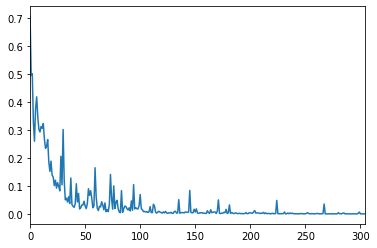

In [79]:
pd.Series(train_loss_history).plot()

# Validation accuracy curve
X-axis: Epochs, Y-axis: validation accuracy

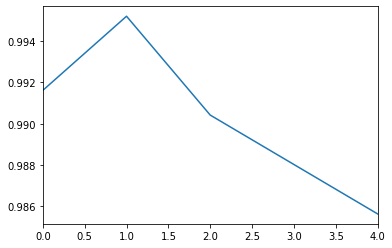

In [80]:
pd.Series(val_accuracy_history).plot()

## You should expect to get test accuracy >= 95.

In [81]:
# Reload best model from saved checkpoint
# Compute test accuracy
model = torch.load('best_model.pt')
test_accuracy = evaluate(model, test_loader,device)
print(test_accuracy)

0.9952095808383233


## Optional Bonus Questions: 
(If you scored full mark (total: 100) in all previous sections, you won't get additional marks so you probably won't need this. But you will get additional bonus marks for answering this if your score is below 100.)

1. What are the problems with recurrent neural networks (RNNs) and how do we overcome them?
Generally, for RNN, it has The Vanishing Gradient Problem, For instance, 1000 epochs might be enough to get the final weight for the time point t, but insufficient for training the weights for the time point t-3 due to a very low gradient at this point. Thus we can initialize weights so that the potential for vanishing gradient is minimized or use LSTM. In our case, when we try to guess what is the next words, RNN may not be able to analyze more sentences as the LSTM.



2. What is the benefit of using the mean or max pooling of hidden states of LSTM instead of using the last hidden state of LSTM?
Instead of using the last hidden layer which can not be fully trained, the average pooling is represented by all words contained; max pooling is represented by a small number of keywords and their salient features. Which will take all the sentences into consideration.
## Answers:



